<a href="https://colab.research.google.com/github/AnastasiiaVladimirovna/transcriptomics_homeworks/blob/main/hw7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 # EM-алгоритм

In [ ]:
!pip3 install scanpy scrublet scikit-misc anndata2ri

import os
os.kill(os.getpid(), 9)

In [9]:
# Загрузка и прочтение датасета
import scanpy as sc
import seaborn as sns
import pandas as pd
import numpy as np

sc.set_figure_params(dpi=150)
sns.set_style("ticks")

!wget https://cf.10xgenomics.com/samples/cell-exp/6.1.0/10k_PBMC_3p_nextgem_Chromium_X/10k_PBMC_3p_nextgem_Chromium_X_raw_feature_bc_matrix.h5
adata = sc.read_10x_h5("10k_PBMC_3p_nextgem_Chromium_X_raw_feature_bc_matrix.h5")
adata.var_names_make_unique()

--2022-12-28 11:36:21--  https://cf.10xgenomics.com/samples/cell-exp/6.1.0/10k_PBMC_3p_nextgem_Chromium_X/10k_PBMC_3p_nextgem_Chromium_X_raw_feature_bc_matrix.h5
Resolving cf.10xgenomics.com (cf.10xgenomics.com)... 104.18.0.173, 104.18.1.173, 2606:4700::6812:1ad, ...
Connecting to cf.10xgenomics.com (cf.10xgenomics.com)|104.18.0.173|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 62760214 (60M) [binary/octet-stream]
Saving to: ‘10k_PBMC_3p_nextgem_Chromium_X_raw_feature_bc_matrix.h5.1’

10k_PBMC_3p_nextgem 100%[===================>]  59.85M   175MB/s    in 0.3s    

2022-12-28 11:36:22 (175 MB/s) - ‘10k_PBMC_3p_nextgem_Chromium_X_raw_feature_bc_matrix.h5.1’ saved [62760214/62760214]



/usr/local/lib/python3.8/dist-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


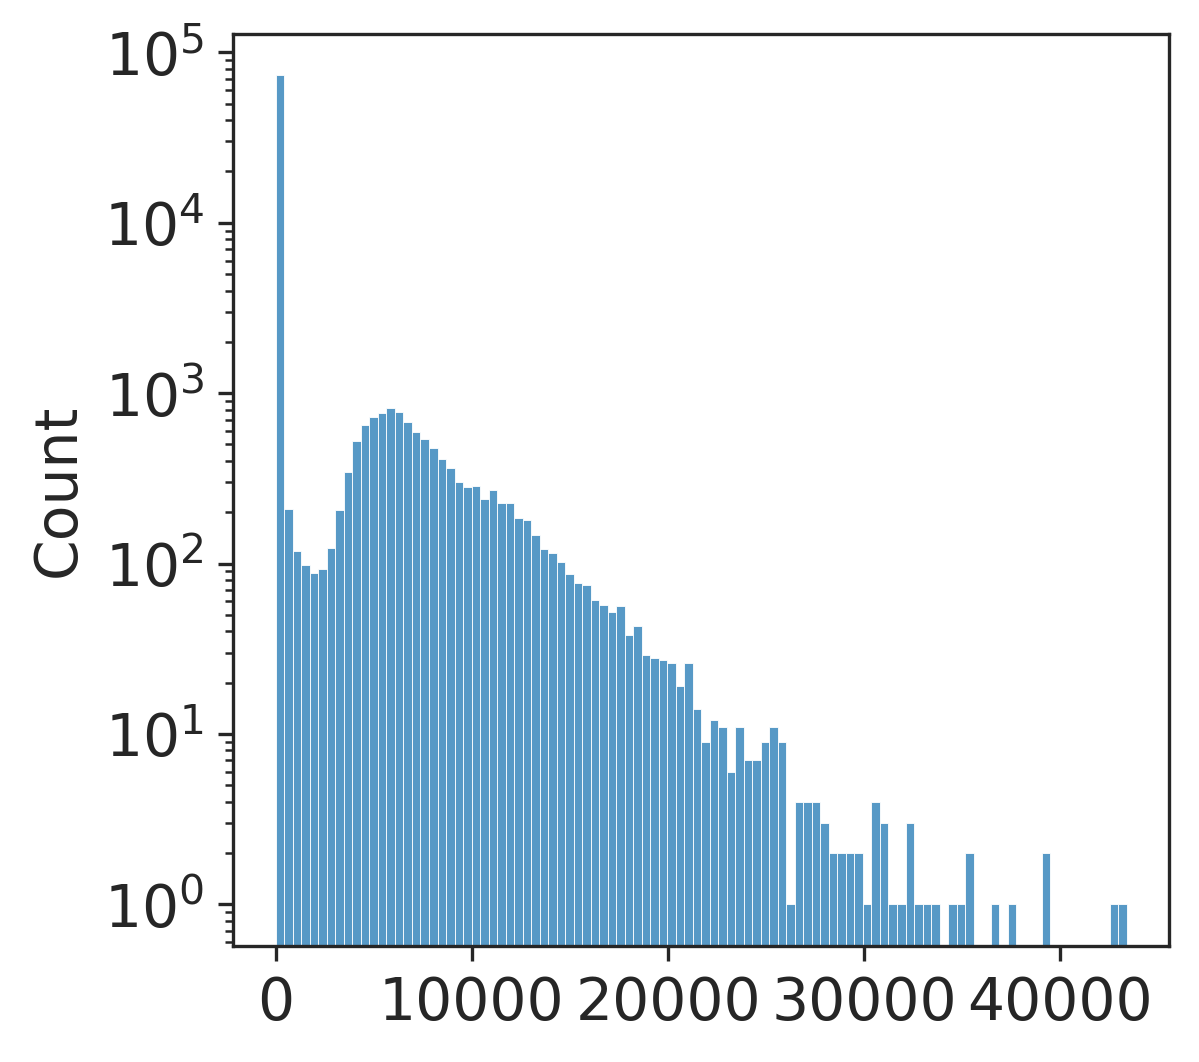

In [ ]:
min_umi = 10
adata = adata[adata.X.sum(axis=1).A.T[0] >= min_umi]


ax = sns.histplot(adata.X.sum(axis=1).A.T[0], bins=100)
ax.set_yscale("log")

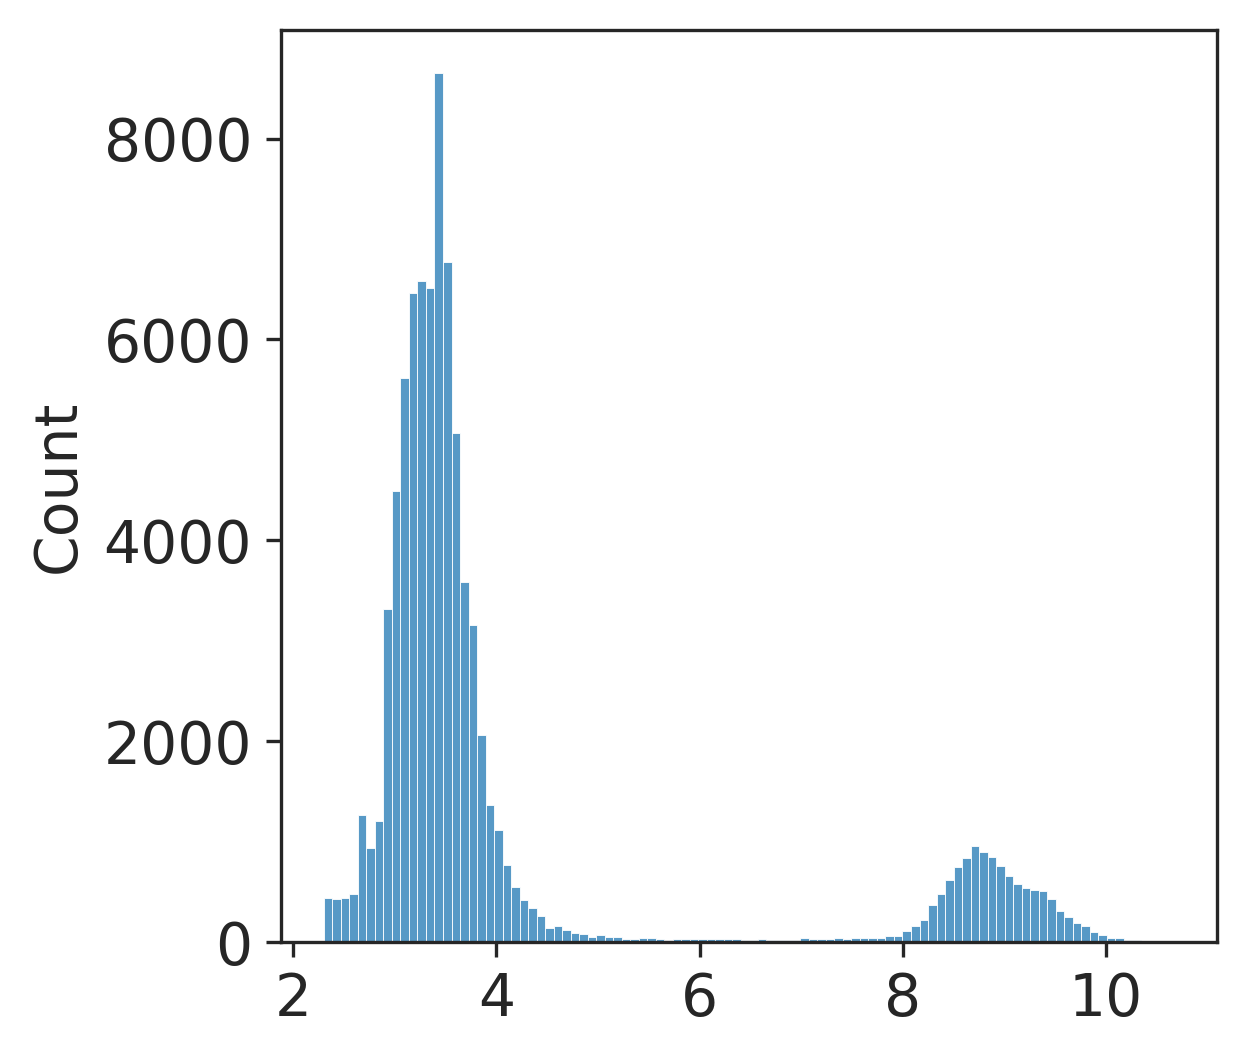

In [ ]:
ax = sns.histplot(np.log(adata.X.sum(axis=1).A.T[0]), bins=100)

Сделаем сначала как на семинаре, чтобы сравнивать

phi_real: 0.11704941826439122
phi_empty: 0.4414752908678044
mu_real: 9.210340371976184
mu_int: 6.214608098422191
mu_empty: 2.302585092994046
sigma_real: 1
sigma_int: 1
sigma_empty: 1


Text(0.5, 1.0, 'Start position')

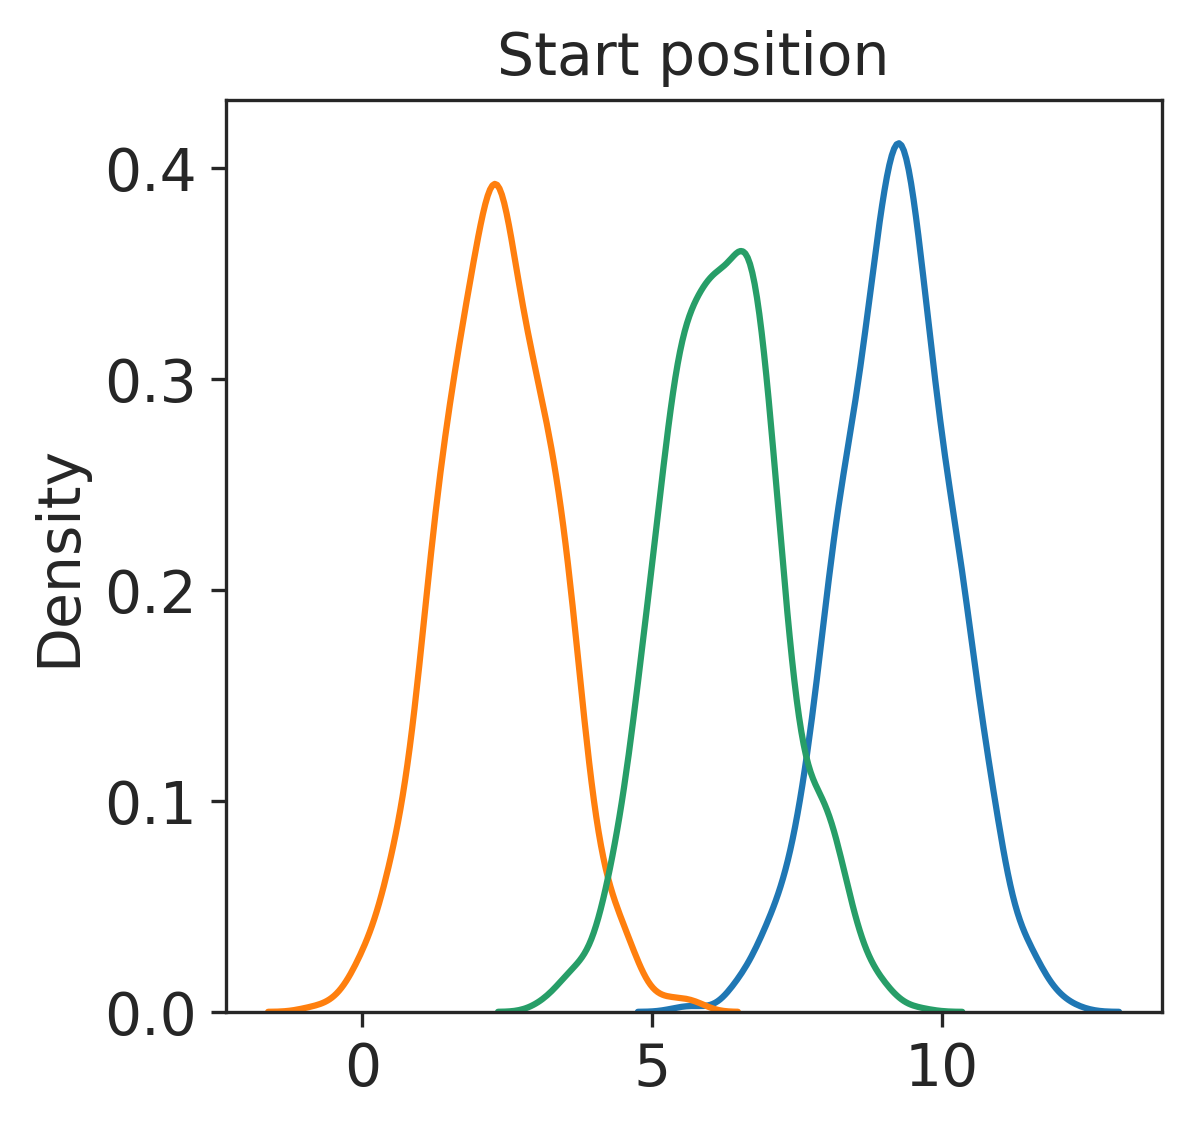

In [ ]:
import scipy.stats as stats
import scipy.stats as stats
from scipy.special import logsumexp

X = np.log(adata.X.sum(axis=1).A.T[0])
expected_cells = 10000 / len(adata)

params = {
  "phi_real" : expected_cells,
  "phi_empty" : (1 - expected_cells) / 2,
  "mu_real" : np.log(10000),
  "mu_int" : np.log(500),
  "mu_empty" : np.log(10),
  "sigma_real" : 1,
  "sigma_int" : 1,
  "sigma_empty" : 1
}

for param in params:
  print(f"{param}: {params[param]}")

params_start = params.copy()

start_real = stats.norm(params["mu_real"], params["sigma_real"]).rvs(size=1000)
start_int = stats.norm(params["mu_int"], params["sigma_int"]).rvs(size=1000)
start_empty = stats.norm(params["mu_empty"], params["sigma_empty"]).rvs(size=1000)

ax = sns.kdeplot(start_real)
ax = sns.kdeplot(start_empty)
ax = sns.kdeplot(start_int)
ax.set_title("Start position")

In [ ]:
def E_step(X, params, draw=False):
  LogProb = np.log([
      stats.norm(params["mu_empty"], params["sigma_empty"]).pdf(X),
      stats.norm(params["mu_int"], params["sigma_int"]).pdf(X), 
      stats.norm(params["mu_real"], params["sigma_real"]).pdf(X)
  ])
  logPrior = np.log([params["phi_empty"], 1 - params["phi_real"] - params["phi_empty"], params["phi_real"]])
  logNum = logPrior + LogProb.T
  RealSoftMax = logsumexp(logNum, axis=1)
  probabilities = np.exp(logNum - np.array([RealSoftMax]).T)
  return RealSoftMax, probabilities

In [ ]:
def M_step(X, params, probabilities):
  prob_empty = probabilities[:, 0]
  prob_int = probabilities[:, 1]
  prob_real = probabilities[:, 2]

  # Вычисление новых значений
  phi_empty = prob_empty.sum() / len(X)
  phi_real = prob_real.sum() / len(X)

  mu_empty = prob_empty.dot(X) / np.sum(prob_empty)
  mu_int = prob_int.dot(X) / np.sum(prob_int)
  mu_real = prob_real.dot(X) / np.sum(prob_real)

  sigma_empty = (np.sum(prob_empty * (X - mu_empty) ** 2) / np.sum(prob_empty)) ** 0.5
  sigma_int = (np.sum(prob_int * (X - mu_int) ** 2) / np.sum(prob_int)) ** 0.5
  sigma_real = (np.sum(prob_real * (X - mu_real) ** 2) / np.sum(prob_real)) ** 0.5

  return {
      "phi_empty" : phi_empty,
      "phi_real" : phi_real,
      "mu_empty" : mu_empty,
      "mu_int" : mu_int,
      "mu_real" : mu_real,
      "sigma_empty": sigma_empty,
      "sigma_int": sigma_int,
      "sigma_real": sigma_real
  }

In [ ]:
def run_EM(X, params):
    avg_allprob = []

    while True:
        allprob, probabilities = E_step(X, params)
        avg_allprob.append(np.mean(probabilities))
        if len(avg_allprob) > 2 and abs(avg_allprob[-1] - avg_allprob[-2]) < 0.00001:
            break
        params = M_step(X, params, probabilities)

    allprob, probabilities = E_step(X, params)
    forecasts = np.argmax(probabilities, axis=1)
    return forecasts, probabilities, avg_allprob

In [ ]:
pred, prob, avg_allprob = run_EM(X, params)

Text(0.5, 1.0, 'Final position')

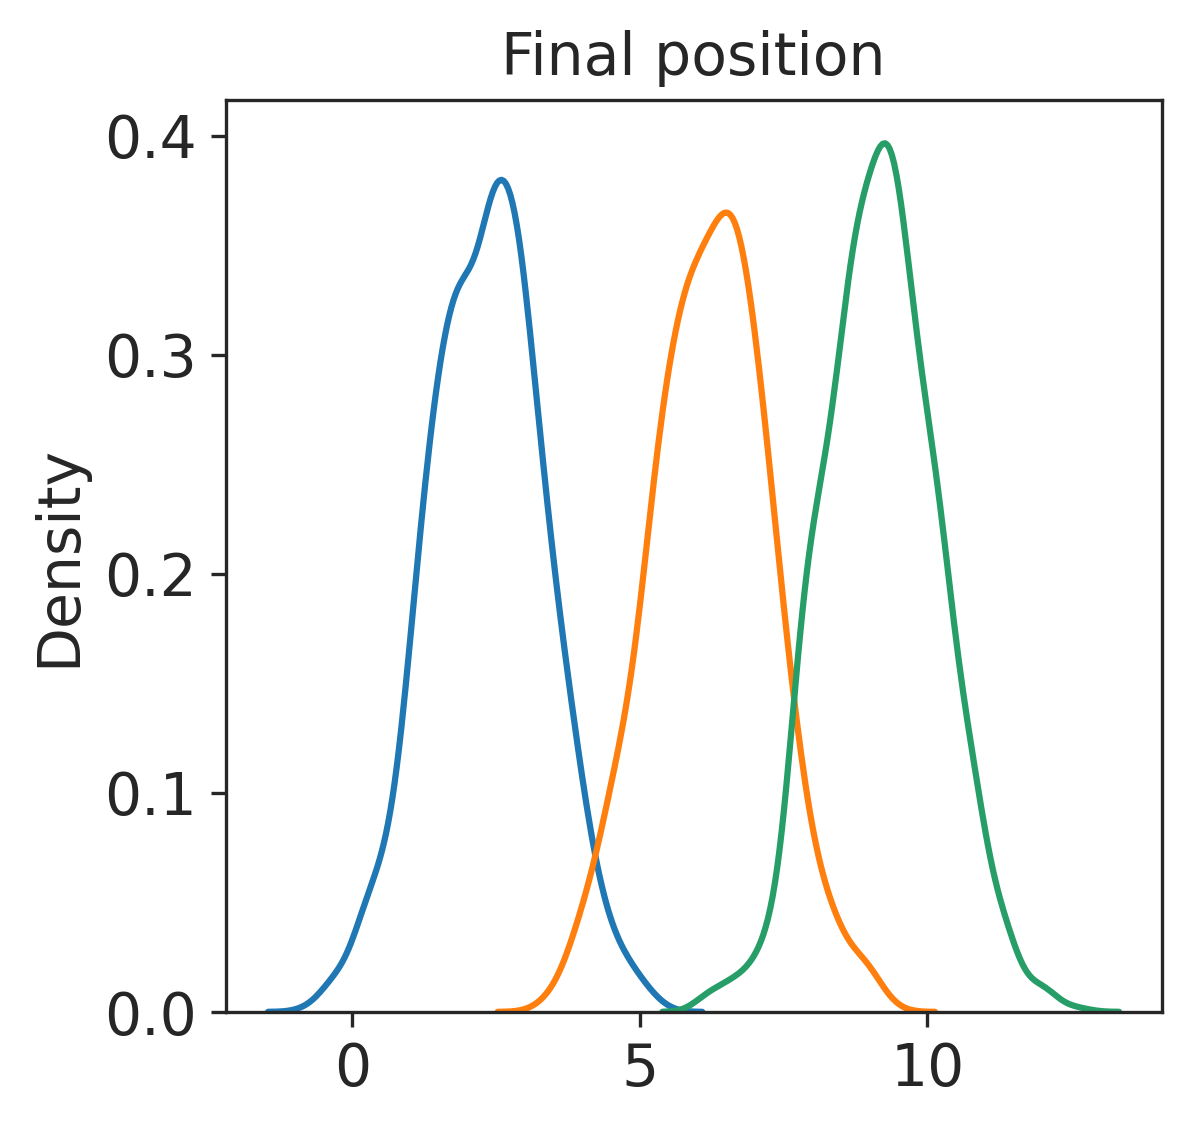

In [ ]:
final_real = stats.norm(params["mu_real"], params["sigma_real"]).rvs(size=1000)
final_int = stats.norm(params["mu_int"], params["sigma_int"]).rvs(size=1000)
final_empty = stats.norm(params["mu_empty"], params["sigma_empty"]).rvs(size=1000)

ax = sns.kdeplot(final_empty)
ax = sns.kdeplot(final_int)
ax = sns.kdeplot(final_real)
ax.set_title("Final position")

<AxesSubplot: ylabel='Count'>

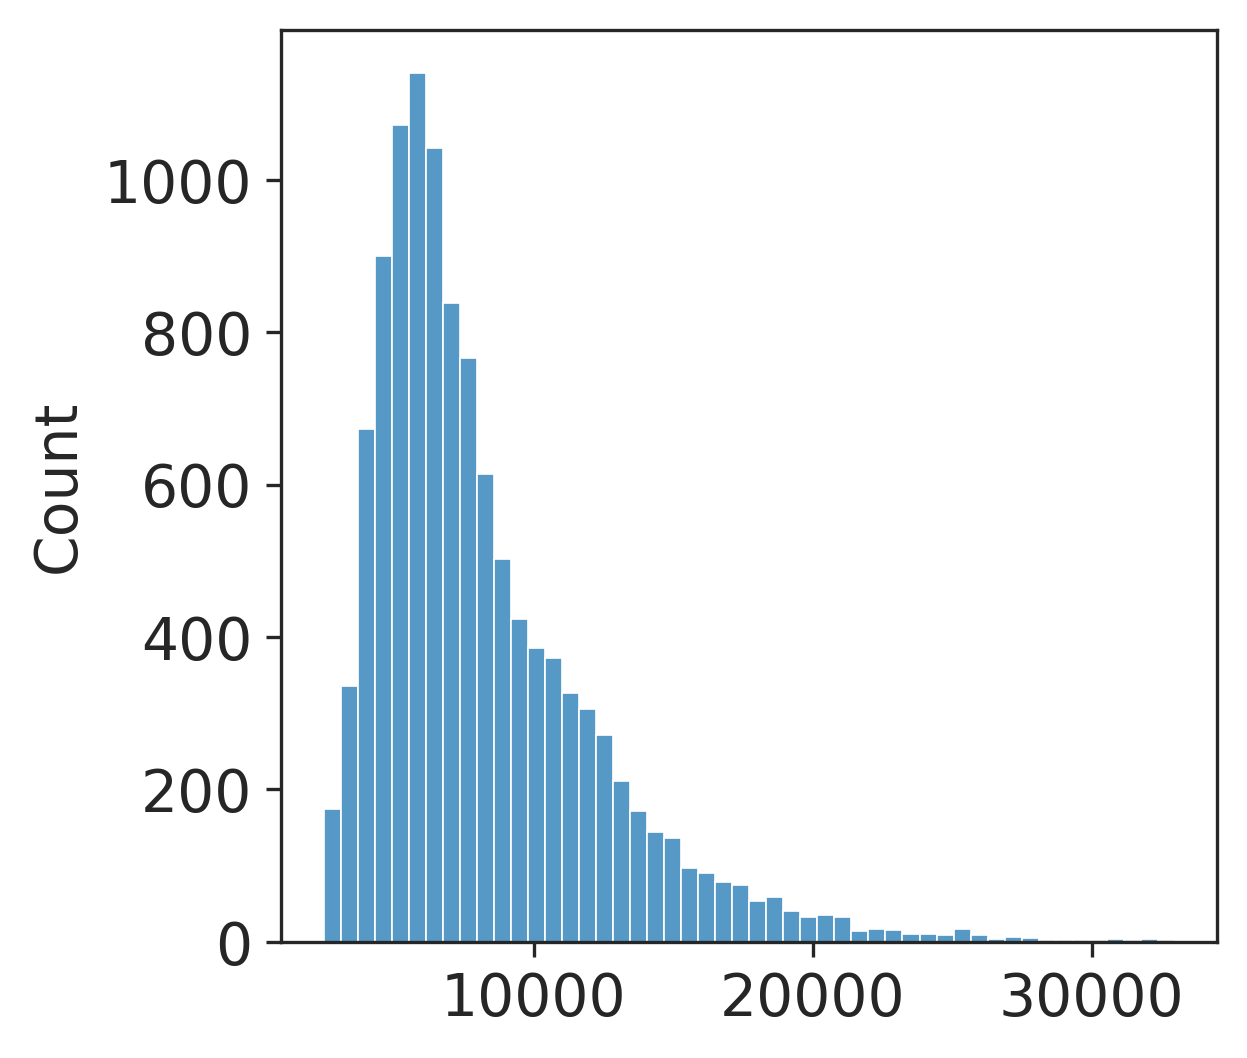

In [ ]:
sns.histplot(adata.X.sum(axis=1).A.T[0][pred == 2], bins=50)

Попробуем подвинуть значения mu распределений ближе друг к другу

phi_real: 0.11704941826439122
phi_empty: 0.4414752908678044
mu_real: 6.907755278982137
mu_int: 6.309918278226516
mu_empty: 4.605170185988092
sigma_real: 1
sigma_int: 1
sigma_empty: 1


Text(0.5, 1.0, 'Start position')

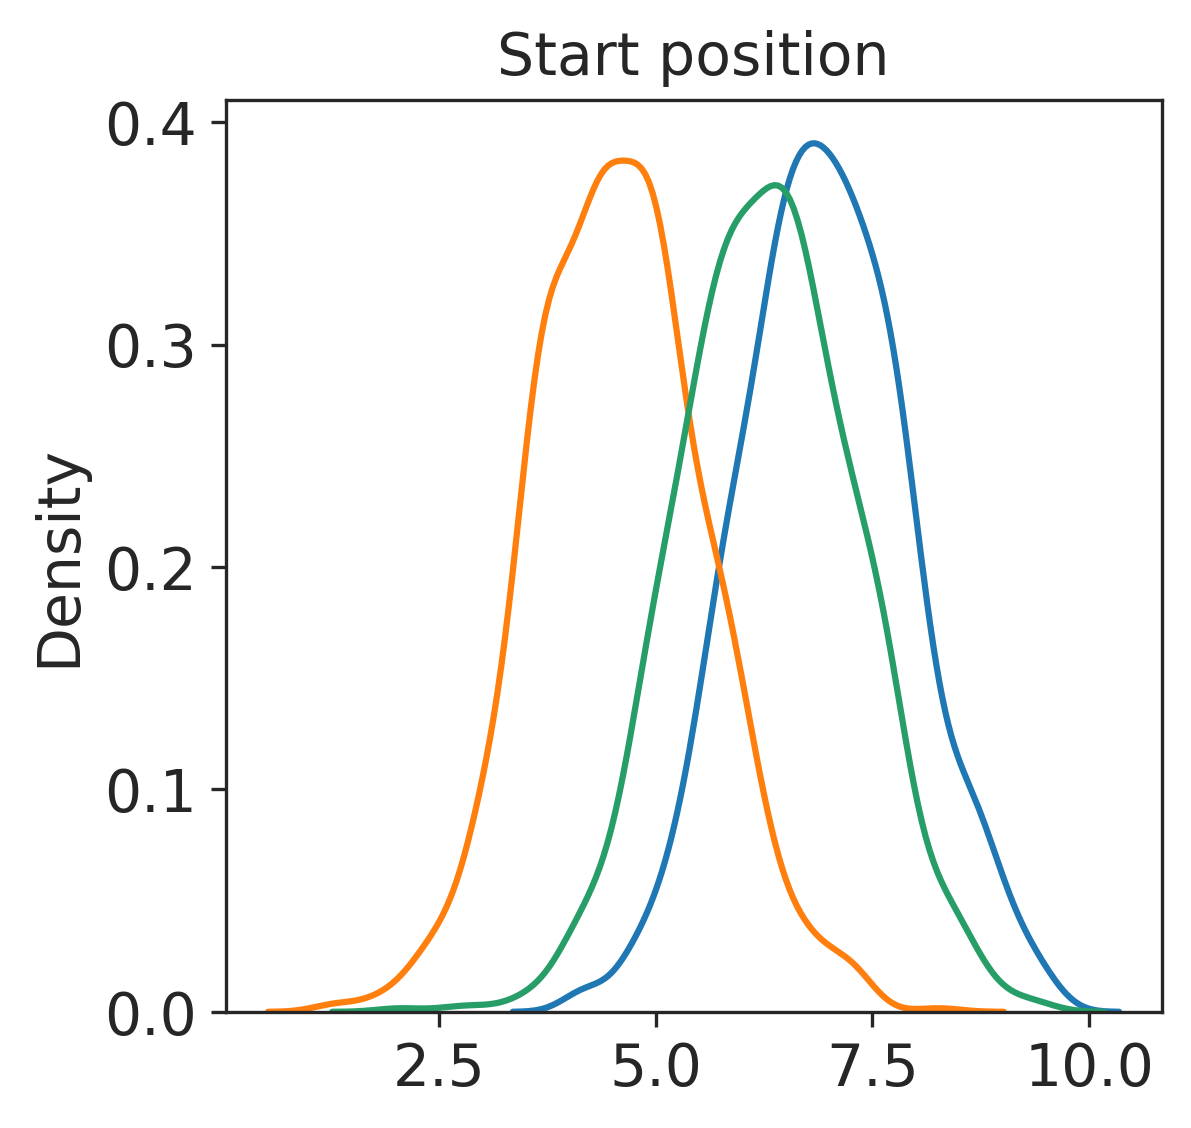

In [ ]:
import scipy.stats as stats
import scipy.stats as stats
from scipy.special import logsumexp

X = np.log(adata.X.sum(axis=1).A.T[0])
expected_cells = 10000 / len(adata)

params = {
  "phi_real" : expected_cells,
  "phi_empty" : (1 - expected_cells) / 2,
  "mu_real" : np.log(1000),
  "mu_int" : np.log((1000+100)/2),
  "mu_empty" : np.log(100),
  "sigma_real" : 1,
  "sigma_int" : 1,
  "sigma_empty" : 1
}

for param in params:
  print(f"{param}: {params[param]}")

params_start = params.copy()

start_real = stats.norm(params["mu_real"], params["sigma_real"]).rvs(size=1000)
start_int = stats.norm(params["mu_int"], params["sigma_int"]).rvs(size=1000)
start_empty = stats.norm(params["mu_empty"], params["sigma_empty"]).rvs(size=1000)

ax = sns.kdeplot(start_real)
ax = sns.kdeplot(start_empty)
ax = sns.kdeplot(start_int)
ax.set_title("Start position")

In [ ]:
pred, prob, avg_allprob = run_EM(X, params)

Text(0.5, 1.0, 'Final position')

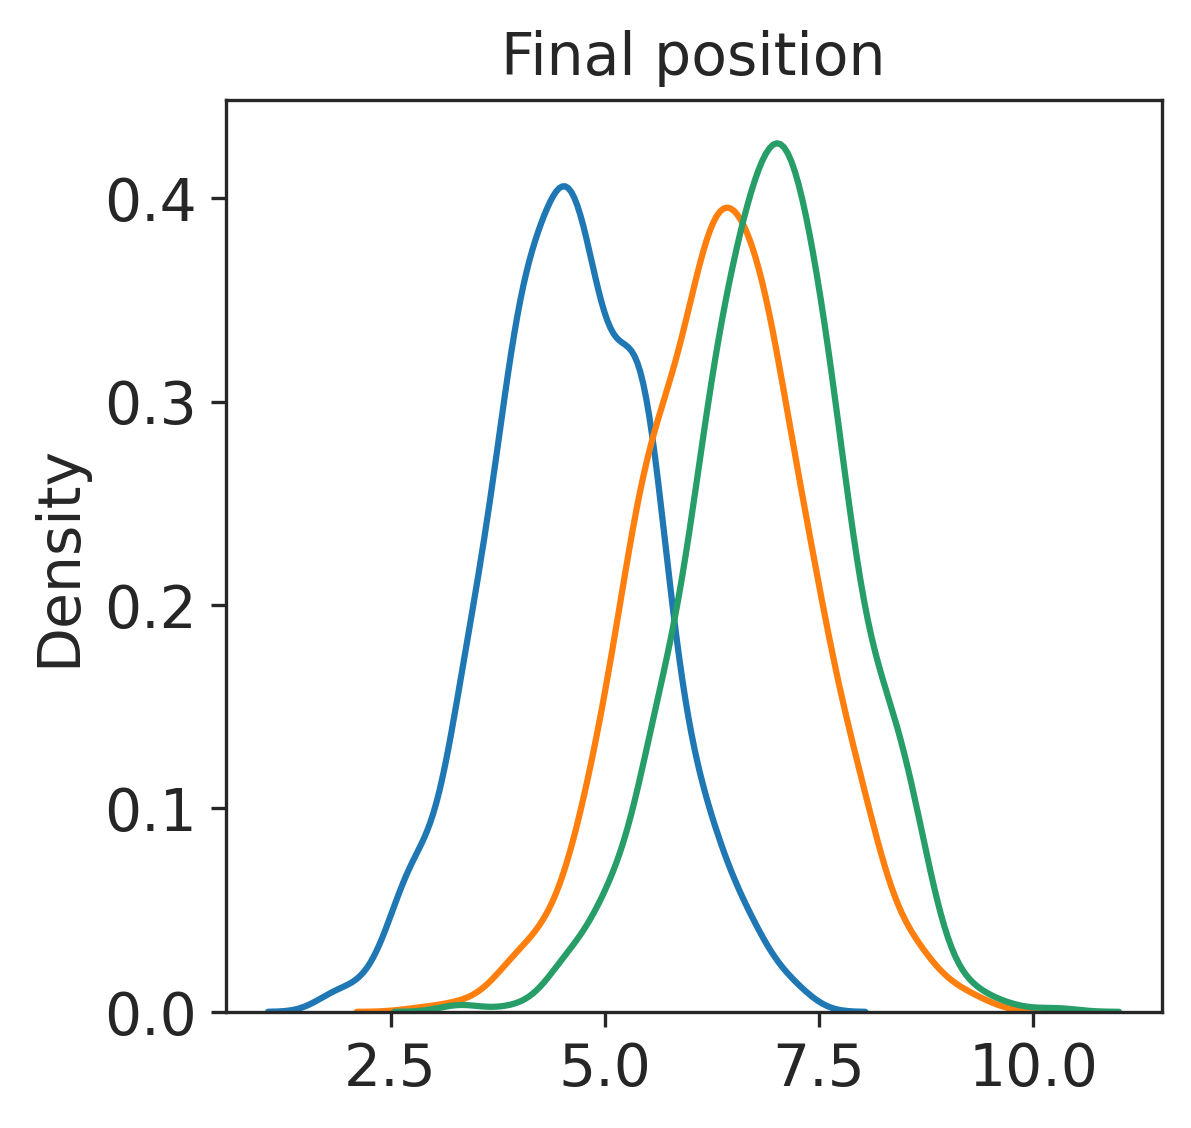

In [ ]:
final_real = stats.norm(params["mu_real"], params["sigma_real"]).rvs(size=1000)
final_int = stats.norm(params["mu_int"], params["sigma_int"]).rvs(size=1000)
final_empty = stats.norm(params["mu_empty"], params["sigma_empty"]).rvs(size=1000)

ax = sns.kdeplot(final_empty)
ax = sns.kdeplot(final_int)
ax = sns.kdeplot(final_real)
ax.set_title("Final position")

<AxesSubplot: ylabel='Count'>

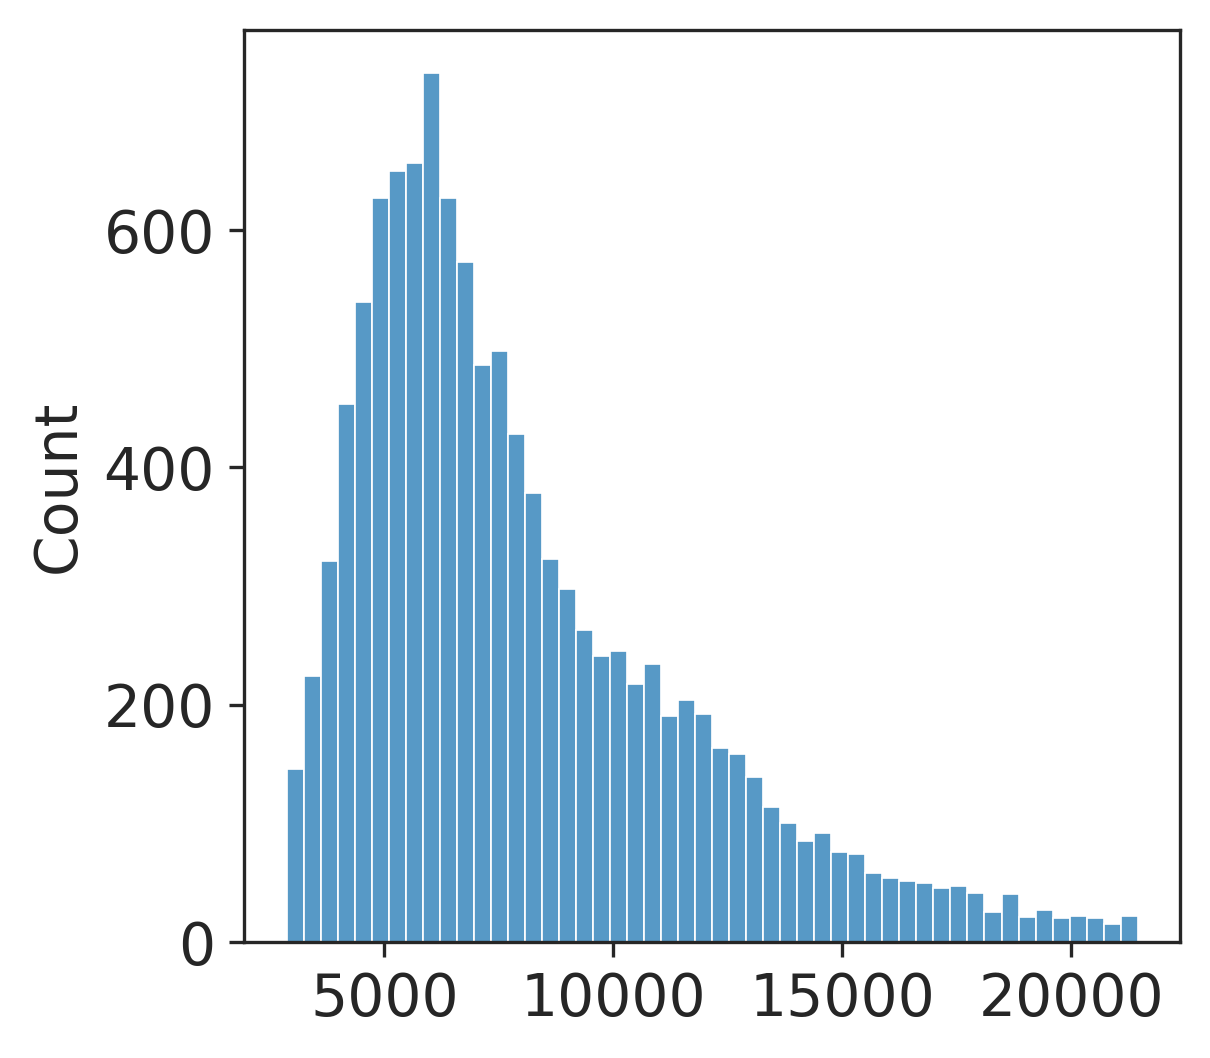

In [ ]:
sns.histplot(adata.X.sum(axis=1).A.T[0][pred == 2], bins=50)

Стало все прям хуже, в данном случае мы берем меньше клеток с большим количеством каунтов.

Попробуем поменять дисперсию

phi_real: 0.11704941826439122
phi_empty: 0.4414752908678044
mu_real: 9.210340371976184
mu_int: 6.214608098422191
mu_empty: 2.302585092994046
sigma_real: 10
sigma_int: 10
sigma_empty: 10


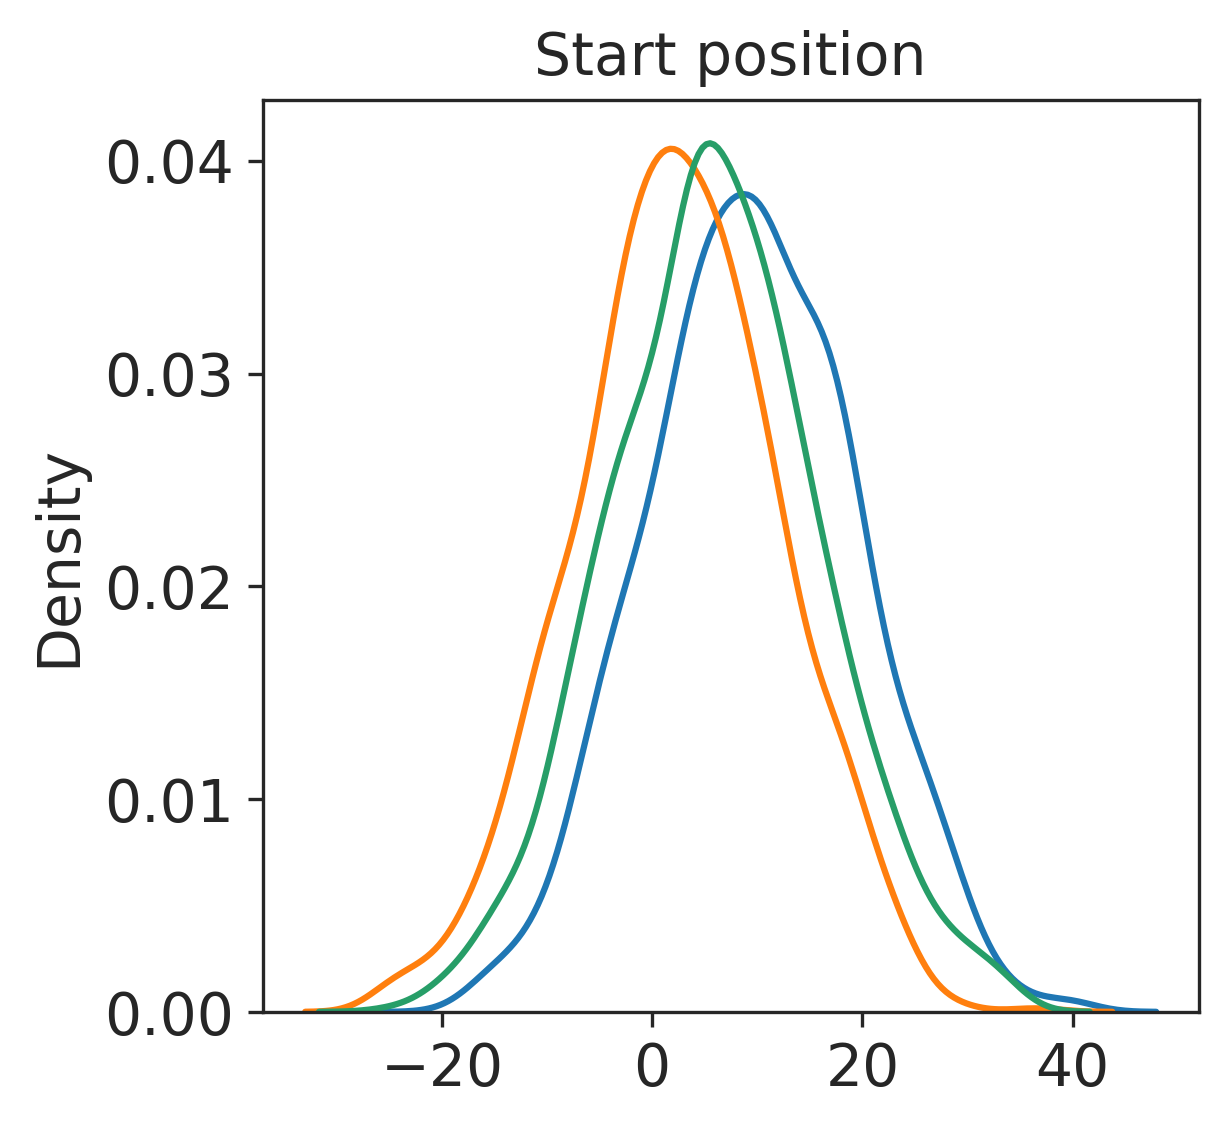

In [ ]:
import scipy.stats as stats
import scipy.stats as stats
from scipy.special import logsumexp

X = np.log(adata.X.sum(axis=1).A.T[0])
expected_cells = 10000 / len(adata)

params = {
  "phi_real" : expected_cells,
  "phi_empty" : (1 - expected_cells) / 2,
  "mu_real" : np.log(10000),
  "mu_int" : np.log(500),
  "mu_empty" : np.log(10),
  "sigma_real" : 10,
  "sigma_int" : 10,
  "sigma_empty" : 10
}

for param in params:
  print(f"{param}: {params[param]}")

params_start = params.copy()

start_real = stats.norm(params["mu_real"], params["sigma_real"]).rvs(size=1000)
start_int = stats.norm(params["mu_int"], params["sigma_int"]).rvs(size=1000)
start_empty = stats.norm(params["mu_empty"], params["sigma_empty"]).rvs(size=1000)

ax = sns.kdeplot(start_real)
ax = sns.kdeplot(start_empty)
ax = sns.kdeplot(start_int)
ax.set_title("Start position")

pred, prob, avg_allprob = run_EM(X, params)

Text(0.5, 1.0, 'Final position')

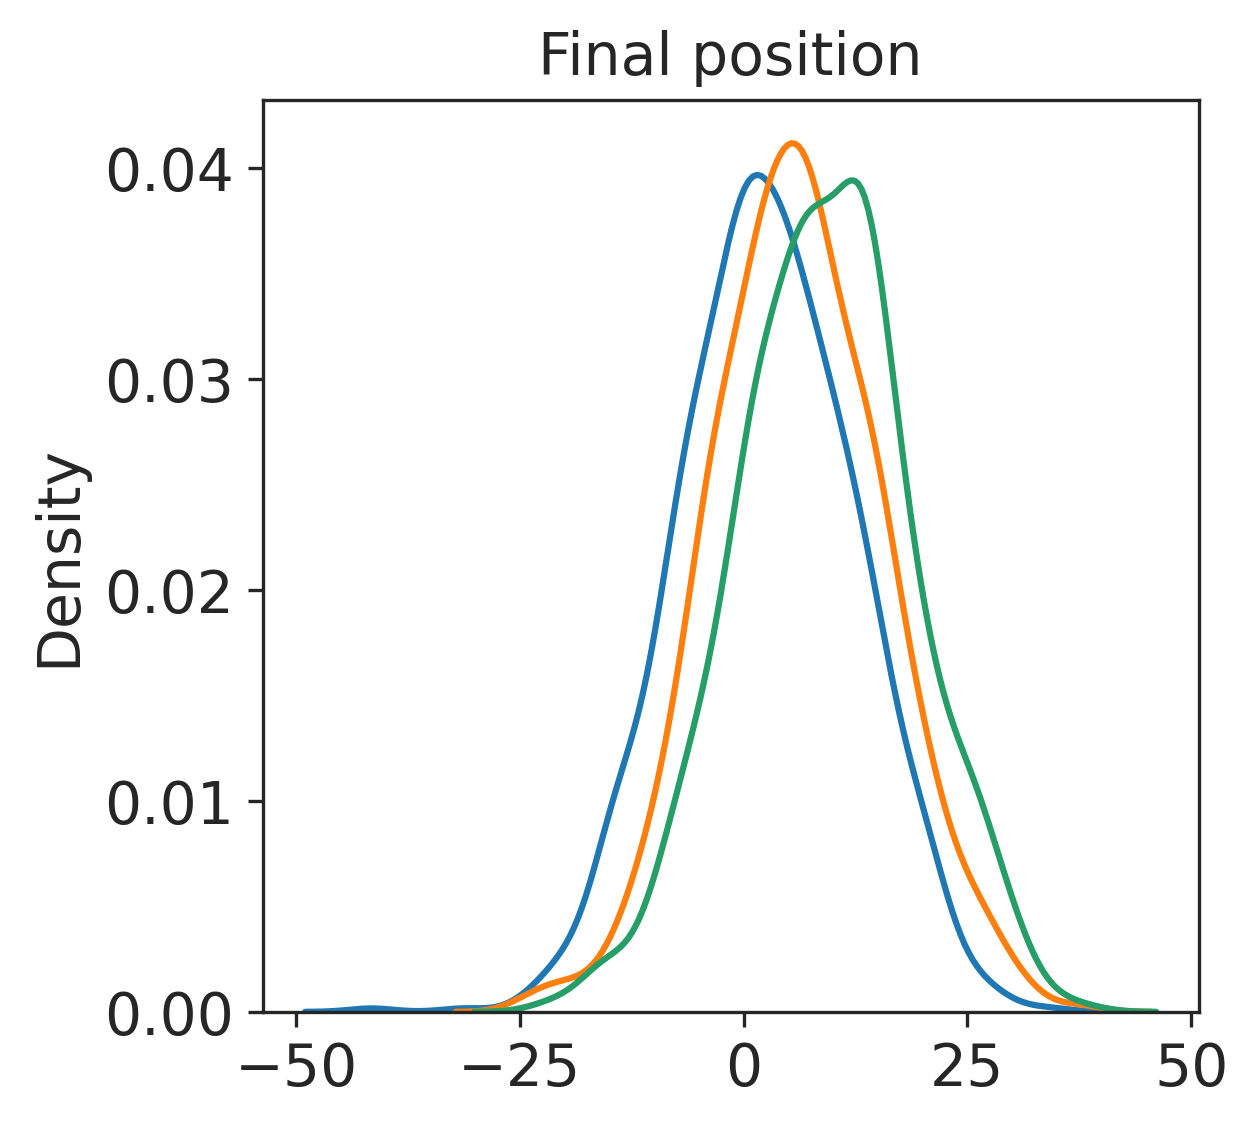

In [ ]:
final_real = stats.norm(params["mu_real"], params["sigma_real"]).rvs(size=1000)
final_int = stats.norm(params["mu_int"], params["sigma_int"]).rvs(size=1000)
final_empty = stats.norm(params["mu_empty"], params["sigma_empty"]).rvs(size=1000)

ax = sns.kdeplot(final_empty)
ax = sns.kdeplot(final_int)
ax = sns.kdeplot(final_real)
ax.set_title("Final position")

Так оно прям совсем не справилось

Попробуем поменять дисперсию только промежуточного распредления, мне кажется так тоже ничего не выйдет

phi_real: 0.11704941826439122
phi_empty: 0.4414752908678044
mu_real: 9.210340371976184
mu_int: 6.214608098422191
mu_empty: 2.302585092994046
sigma_real: 1
sigma_int: 10
sigma_empty: 1


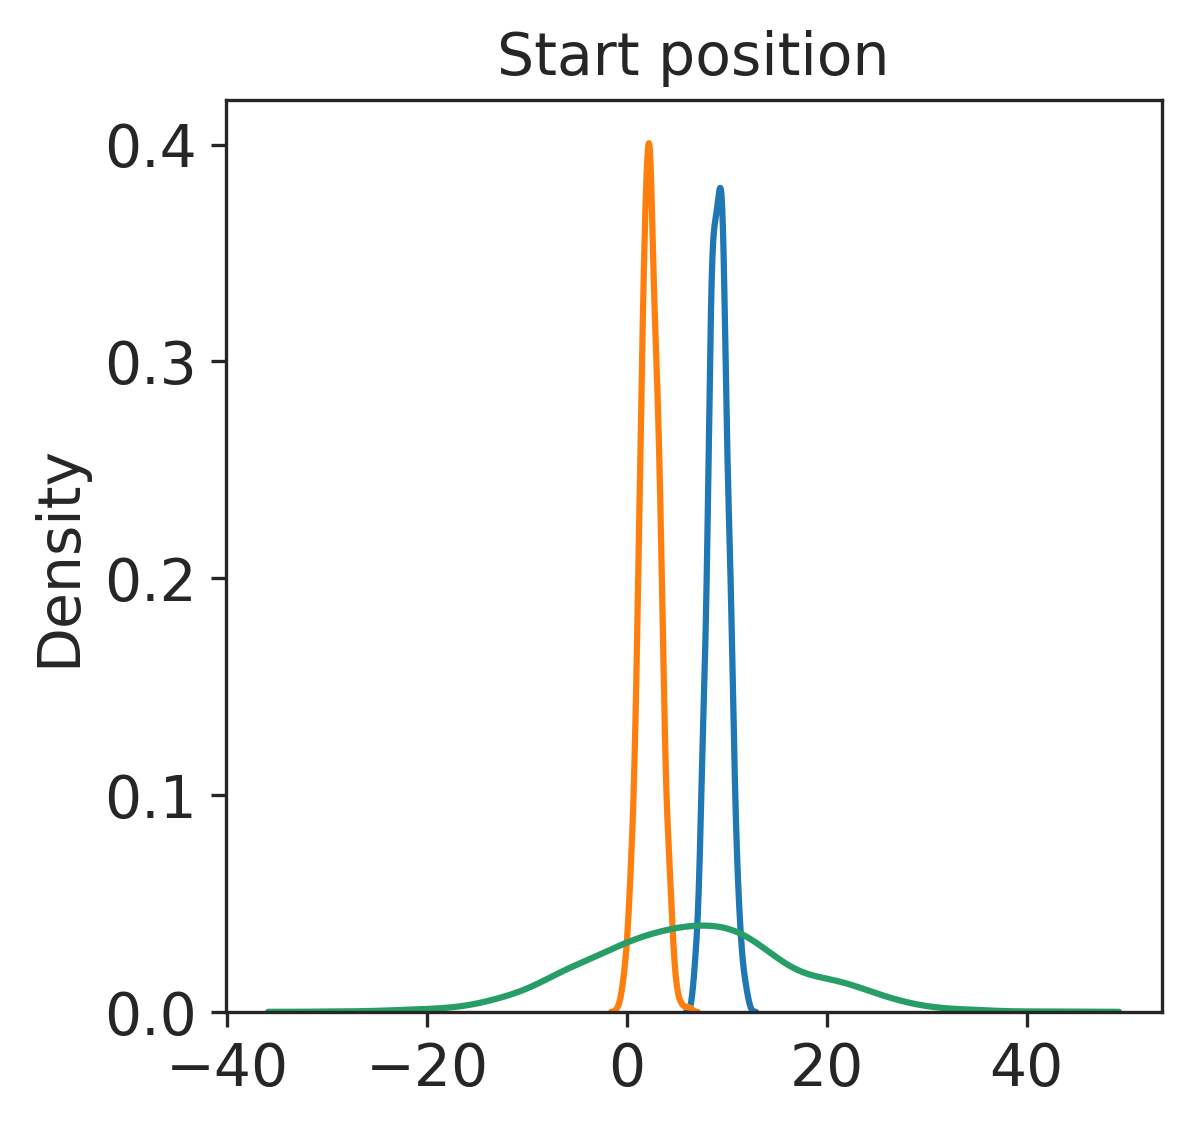

In [ ]:
import scipy.stats as stats
import scipy.stats as stats
from scipy.special import logsumexp

X = np.log(adata.X.sum(axis=1).A.T[0])
expected_cells = 10000 / len(adata)

params = {
  "phi_real" : expected_cells,
  "phi_empty" : (1 - expected_cells) / 2,
  "mu_real" : np.log(10000),
  "mu_int" : np.log(500),
  "mu_empty" : np.log(10),
  "sigma_real" : 1,
  "sigma_int" : 10,
  "sigma_empty" : 1
}

for param in params:
  print(f"{param}: {params[param]}")

params_start = params.copy()

start_real = stats.norm(params["mu_real"], params["sigma_real"]).rvs(size=1000)
start_int = stats.norm(params["mu_int"], params["sigma_int"]).rvs(size=1000)
start_empty = stats.norm(params["mu_empty"], params["sigma_empty"]).rvs(size=1000)

ax = sns.kdeplot(start_real)
ax = sns.kdeplot(start_empty)
ax = sns.kdeplot(start_int)
ax.set_title("Start position")

pred, prob, avg_allprob = run_EM(X, params)

Text(0.5, 1.0, 'Final position')

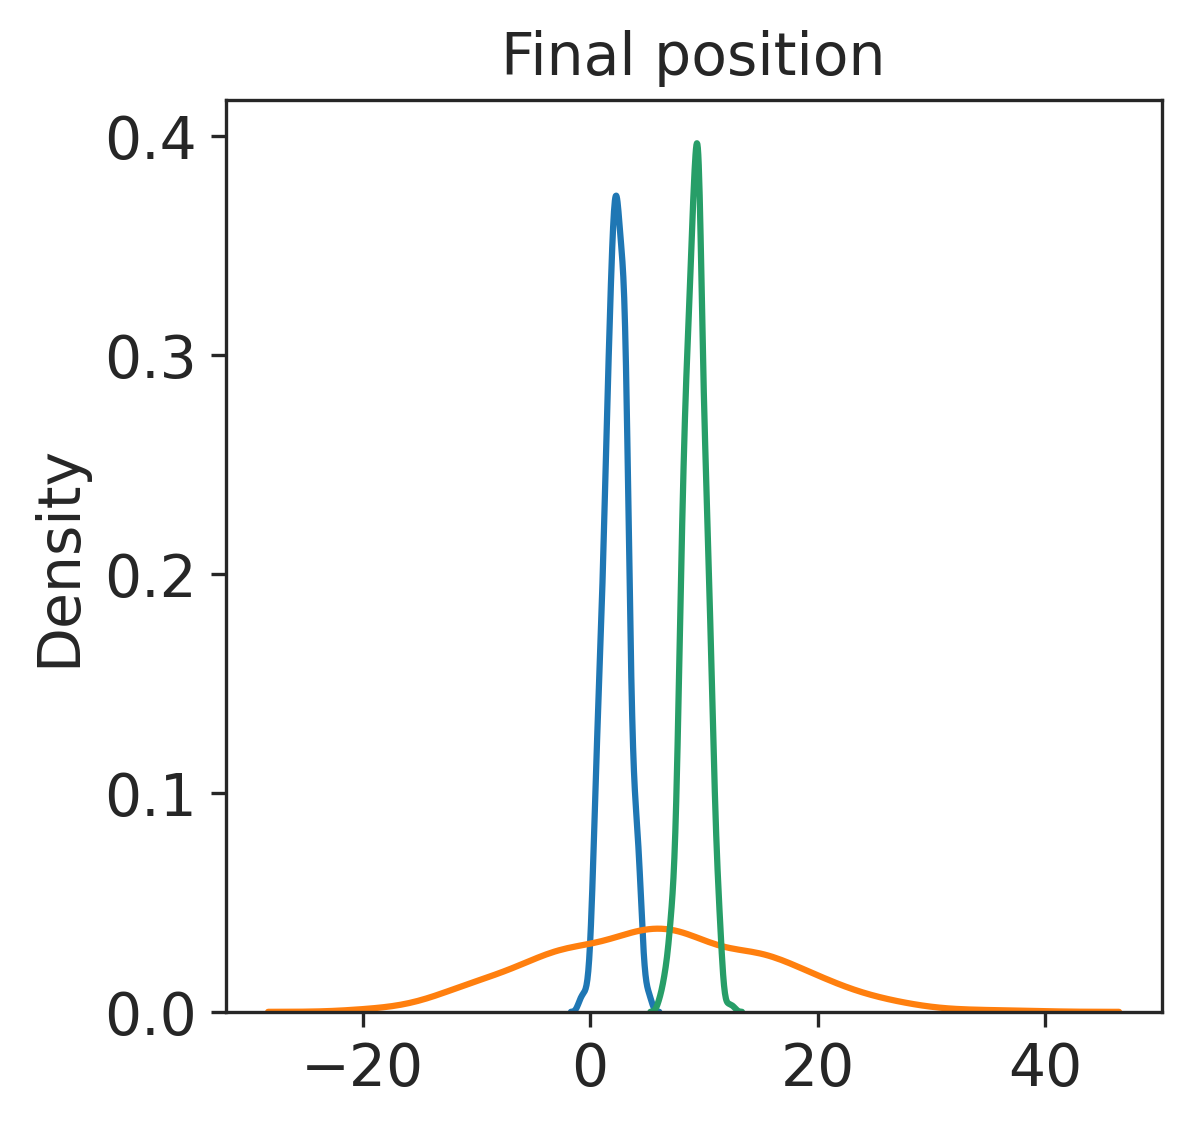

In [ ]:
final_real = stats.norm(params["mu_real"], params["sigma_real"]).rvs(size=1000)
final_int = stats.norm(params["mu_int"], params["sigma_int"]).rvs(size=1000)
final_empty = stats.norm(params["mu_empty"], params["sigma_empty"]).rvs(size=1000)

ax = sns.kdeplot(final_empty)
ax = sns.kdeplot(final_int)
ax = sns.kdeplot(final_real)
ax.set_title("Final position")

Ну да, все плохо

Я бы сделала вывод из такого, что все же оно довольно не устойчиво к параметрам изначальной инициализации, все будет работать, если задавать эти параметры, отталкиваясь от графика распределения, который мы строили в самом начале

# NextFlow-пайплайн

In [ ]:
!pip3 install scanpy scrublet scikit-misc anndata2ri

import os
os.kill(os.getpid(), 9)


In [1]:
!wget https://ftp-trace.ncbi.nlm.nih.gov/sra/sdk/3.0.0/sratoolkit.3.0.0-ubuntu64.tar.gz
!tar -xvzf sratoolkit.3.0.0-ubuntu64.tar.gz
!sratoolkit.3.0.0-ubuntu64/bin/vdb-config -i
!curl -fsSL https://get.nextflow.io | bash

!git clone https://github.com/pachterlab/kallisto.git
!apt-get install autoconf
!cd kallisto && mkdir build && cd build && cmake .. && make


      N E X T F L O W
      version 22.10.4 build 5836
      created 09-12-2022 09:58 UTC 
      cite doi:10.1038/nbt.3820
      http://nextflow.io


Nextflow installation completed. Please note:
- the executable file `nextflow` has been created in the folder: /content
- you may complete the installation by moving it to a directory in your $PATH

fatal: destination path 'kallisto' already exists and is not an empty directory.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
autoconf is already the newest version (2.69-11).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 20 not upgraded.
mkdir: cannot create directory ‘build’: File exists


In [ ]:
!wget https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/001/405/GCF_000001405.40_GRCh38.p14/GCF_000001405.40_GRCh38.p14_rna.fna.gz

In [ ]:
!./kallisto/build/src/kallisto index -i transcriptome.idx GCF_000001405.40_GRCh38.p14_rna.fna.gz


[build] loading fasta file GCF_000001405.40_GRCh38.p14_rna.fna.gz
[build] k-mer length: 31
[build] warning: clipped off poly-A tail (longer than 10)
        from 5158 target sequences
[build] warning: replaced 15 non-ACGUT characters in the input sequence
        with pseudorandom nucleotides
[build] counting k-mers ... tcmalloc: large alloc 1610612736 bytes == 0x56192bbae000 @  0x7f44221c8887 0x56189a45982d 0x56189a46140b 0x56189a423f40 0x7f4421048c87 0x56189a42c10a
tcmalloc: large alloc 3221225472 bytes == 0x56198bbae000 @  0x7f44221c8887 0x56189a45982d 0x56189a46140b 0x56189a423f40 0x7f4421048c87 0x56189a42c10a
tcmalloc: large alloc 6442450944 bytes == 0x561a4c48e000 @  0x7f44221c8887 0x56189a45982d 0x56189a46140b 0x56189a423f40 0x7f4421048c87 0x56189a42c10a
done.
[build] building target de Bruijn graph ...  done 
[build] creating equivalence classes ...  done
[build] target de Bruijn graph has 991009 contigs and contains 142754887 k-mers 



In [2]:
!pip install rpy2==3.5.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
%load_ext rpy2.ipython
%R .libPaths("usr/local/lib/R/site-library/")

'/usr/local/li...,'/usr/lib/R/si...,'/usr/lib/R/li...


In [4]:
import anndata2ri
anndata2ri.activate()

In [5]:
import rpy2.robjects as ro

In [ ]:
!apt-get install libgmp3-dev libcairo2-dev libharfbuzz-dev libfribidi-dev libudunits2-dev
!gdown 1W0TuuQospxcasOX5cQdhT_Xd-k7-QAck
!tar xf library.tar.gz

In [ ]:
ro.r('install.packages("anndata")')

Посмотрим, что последий этап пайплайна работает

In [10]:
ro.globalenv["adata_raw"] = adata

In [16]:
ro.r('library(DropletUtils)')
ro.r('e.out <- emptyDrops(assay(adata_raw))')
ro.r('write.csv(e.out, "./out.csv")')

<rpy2.rinterface_lib.sexp.NULLType object at 0x7f10b9d042c0> [RTYPES.NILSXP]

Запишем его в отдельный скрипт DropletUtils.R

```
library(DropletUtils)
library(anndata)
ad <- read_h5ad('content/results/Kalisto/*')
e.out <- emptyDrops(assay(ad))
write.csv(e.out, "content/results/final_res/out.csv")
```

In [23]:
!chmod a+x DropletUtils.R

Сам NextFlow файл будет выглядеть наверное +- так

```
params.results_dir = "results/"
SRA_list = params.SRA.split(",")
params.transcriptome = "/content/transcriptome.idx"

log.info ""
log.info "  Q U A L I T Y   C O N T R O L  "
log.info "================================="
log.info "SRA number         : ${SRA_list}"
log.info "Results location   : ${params.results_dir}"

process DownloadFastQ {
  publishDir "${params.results_dir}"

  input:
    val sra

  output:
    path "${sra}/*"

  script:
    """
    /content/sratoolkit.3.0.0-ubuntu64/bin/fasterq-dump ${sra} -O ${sra}/
    """
}

process Kalisto {
   publishDir "${params.results_dir}"
  
  input:
    path x

  output:
    path "kalisto_res/*"

  script:
    """
    /content/kallisto/build/src/kb count -i ${params.transcriptome} -o kalisto_res -x 10xv3 --h5ad $x
    """
}

process DropletUtils {

  publishDir "${params.results_dir}"

  input:
    path x

  output:
    path "final_res/out.csv"

  script:
    """
    Rscript DropletUtils.R
    """
}


workflow {
  data = Channel.of( SRA_list )
  DownloadFastQ(data)
  Kalisto( DownloadFastQ.out )
  DropletUtils(Kalisto.out)
}
```